*******
<div style="padding:20px;color:black;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#bdd6f5;overflow:hidden;font-weight:500">Prédiction de la consommation d'énergie des bâtiments publiques à Seattle</div>

*******

### Tables des matières<a class="anchor" id="retour"></a>

[Présentation de la partie 2](#Présentation)



* [Partie 2 🛠 Machine Learning (Régression) ](#Partie_2)

    * [2.1 Régression linéaire comme baseline](#Section_2.1)
        * [2.1.a)  Baseline sur données brut](#Section_2.1.a)
        * [2.1.b)  Baseline sur données préparées](#Section_2.1.b)
    * [2.2 Régression linéaire sur données centrées réduite](#Section_2.2)
    * [2.3 Régression Ridge (pénalité L1) ](#Section_2.3)
    * [2.4 Régression LASSO (pénalité L2)](#Section_2.4)
    * [2.5 Régression sur les 3 premières composantes principales ](#Section_2.5)
    * [2.6 Régression linéaire sur données en log ](#Section_2.6)
    * [2.7 Gradient Boosting regressor sur données en log (Scikit Learn) ](#Section_2.7)
    * [2.8 XGBoost](#Section_2.8)
    * [2.9 XGBoost (avec ENERGYSTARScore)](#Section_2.9)


[Conclusion partie 2](#Conclusion)

[Références](#Références)

In [656]:
# Importation des librairies

import pandas as pd
import numpy as np

# Lib pour réaliser des graphiques
import matplotlib.pyplot as plt
import seaborn as sns

# Lib pour mesurer le temps execution
import time


# Lib pour regression linéaire
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor

# Lib pour séparer les données en 2 set
from sklearn.model_selection import train_test_split

# Lib pour travailler sur les données CR
from sklearn import preprocessing
from sklearn.decomposition import PCA
import sklearn.decomposition

# Lib pour réccupérer le RMSE
from sklearn.metrics import mean_squared_error

# Lib pour l'imputation des données manquantes (algorythme des KNN)
from sklearn.impute import KNNImputer

# Lib pour le passage en log
import math

# Lib pour le gridsearch et les métriques
from sklearn.model_selection import GridSearchCV
from sklearn import  metrics

****
<div style="padding:20px;color:black;margin:0;font-size:200%;display:fill;border-radius:5px;background-color:#e9f1fc;overflow:hidden;font-weight:500">Partie 2 🛠 Machine Learning (Régression)</div>
<a class="anchor" id="Partie_2"></a>

****

## Présentation partie 2
<a class="anchor" id="Partie_2"></a>

In [657]:
# Importation des données
df = pd.read_csv("df.csv",sep=";")
df_float = pd.read_csv("df_float.csv",sep=";")
df_objet = pd.read_csv("df_objet.csv",sep=";")

In [658]:
# Suppression des colonnes inutiles
df_float = df_float.drop(columns=["Unnamed: 0"])
df_objet = df_objet.drop(columns=["Unnamed: 0"])
df = df.drop(columns=["Unnamed: 0"])

In [659]:
target=df[["SiteEnergyUse(kBtu)"]]

### Création de fonctions

In [660]:
# Création d'une fonction qui renvoit le RMSE

def rmse(X_test,pred):
    MSE = mean_squared_error(y_test, pred.prediction)
    RMSE = math.sqrt(MSE)
    return print(RMSE)

In [661]:
# Création d'une fonction qui passe un df au log

def df_au_log(data_1):
    val = np.log(data_1.values)
    data_2 = pd.DataFrame(data=val,columns=data_1.columns,index=data_1.index)
    return data_2

In [662]:
# Création d'une fonction composé des coeff de la regression triés par ordre en valeur absolue

def coef_sort(model):
    coef = pd.DataFrame(data=model.coef_,columns=df_float.columns)
    coef = pd.DataFrame(data=coef.transpose().values,columns=["coeff"],
                        index=coef.transpose().index)
    coef["coeff_sort"] = coef["coeff"].abs()
    coef = coef.sort_values(by="coeff_sort",ascending=False)
    return coef

## 2.1) Régression linéaire comme baseline
<a class="anchor" id="Section_2.1"></a>

Ce premier point nous permet deux choses:
- d'avoir un modèle de référence , le modèle sur données brut
- de montrer l'importance de bien comprendre et préparer les données

## 2.1.a) Baseline sur données brut
<a class="anchor" id="Section_2.1.a"></a>

In [663]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float, target, test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps = tps2 - tps1
print("Temps de calcul : ",temps,"ms")

Temps de calcul :  0.005021572113037109 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [664]:
print("R2 sur le set d'apprentissage: ",model.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.8059421253162408 
 R2 sur le set de test:  0.32541784157511466


In [665]:
# Création d'un DF des valeurs prédites de X_test
pred = model.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])
pred

# Affichage du RMSE
rmse(X_test,pred)

14701021.355123838


In [666]:
# Création d'un DF composée de la target la prédiction et les résidus

y_model = y_test.merge(df_float["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_model = pd.DataFrame(y_model).reset_index()
y_model = y_model.drop(columns=["index"])
pred = pd.concat([y_model[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,1.712280e+06,92841,2.844138e+06,-1.131858e+06
1,9.320835e+05,24000,3.951061e+06,-3.018978e+06
2,5.007401e+06,77662,2.941056e+06,2.066345e+06
3,7.052621e+05,24552,6.578032e+05,4.745894e+04
4,3.267787e+05,20088,6.283967e+05,-3.016180e+05
...,...,...,...,...
1006,3.502646e+05,21060,2.775469e+06,-2.425204e+06
1007,1.665662e+06,29520,-1.081310e+06,2.746972e+06
1008,6.293068e+05,20598,-2.740087e+05,9.033155e+05
1009,2.188051e+06,44510,1.567147e+06,6.209043e+05


Text(0.5, 1.0, 'Prédiction de 97% des points')

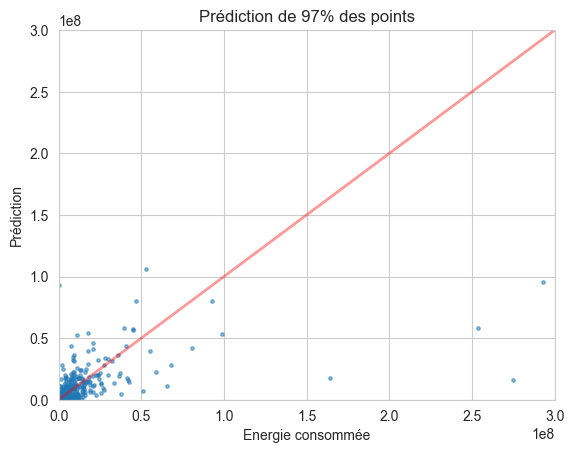

In [667]:
# Représentation graphique de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",alpha=0.5,s=6)
plt.plot([0.0, 300_000_000], [0.0, 300_000_000], 'r-', lw=2,alpha=0.4)

plt.xlim(0, 300_000_000)
plt.ylim(0, 300_000_000)

axes.set_xlabel('Energie consommée')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

In [668]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model)
coef

,coeff,coeff_sort
NumberofBuildings,3.214483e+06,3.214483e+06
NumberofFloors,-4.075592e+05,4.075592e+05
BulType,-9.911839e+04,9.911839e+04
Council,-5.842425e+04,5.842425e+04
PPT,-2.887372e+04,2.887372e+04
years,1.649440e+04,1.649440e+04
Zip,-1.181890e+04,1.181890e+04
Voisin,-7.427340e+03,7.427340e+03
ThirdLargestPropertyUseTypeGFA,3.543657e+02,3.543657e+02
PropertyGFATotal,5.108374e+01,5.108374e+01


In [669]:
model.intercept_

array([-2131221.20793859])

Text(0.5, 1.0, 'Coefficients de regression')

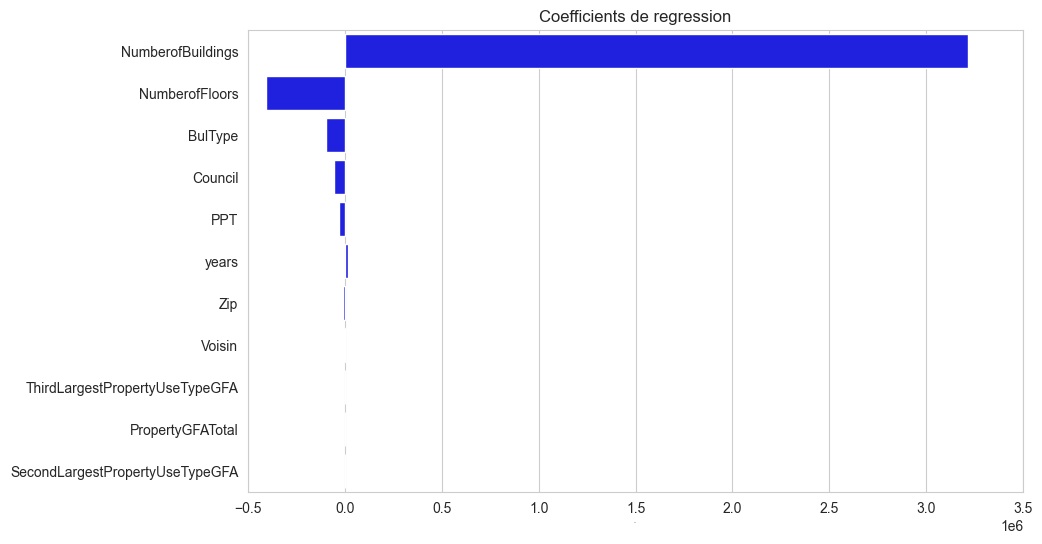

In [670]:
# Bar Plot des coeff

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-500_000, 3_500_000)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.1.b) Baseline sur données préparées
<a class="anchor" id="Section_2.1.b"></a>

Modification des données bruts:
- Filtre sur la variable consommation d'énergie

### Préparation des données

In [671]:
df_float=df_float.drop(columns=["NumberofBuildings"])

In [672]:
# Création de la variable tx_gaz
df_float["tx_gaz"]=df["NaturalGas(kBtu)"]/df["SiteEnergyUse(kBtu)"]
df_float["tx_gaz"] = df_float["tx_gaz"].replace(np.inf, 1)
df_float["tx_gaz"] = df_float["tx_gaz"].fillna(0)

In [673]:
# Suppression des lignes pour lesquelles il n'y a pas de consommation d'énergie

df_float=pd.concat([df_float,df["SiteEnergyUse(kBtu)"]],axis=1)
df_float=df_float[df_float["SiteEnergyUse(kBtu)"]>1]
df=df[df["SiteEnergyUse(kBtu)"]>1]
df_float=df_float.drop(columns=["SiteEnergyUse(kBtu)"])

In [674]:
target=df[["SiteEnergyUse(kBtu)"]]

In [675]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes

df_prep = pd.concat([target,df_float],axis=1)
df_prep = df_prep[df_prep["SiteEnergyUse(kBtu)"]<200_000_000]

df_float = df_prep.drop(columns=["SiteEnergyUse(kBtu)"])
target = df_prep[["SiteEnergyUse(kBtu)"]]

### Modèle linéaire simple

In [676]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float, target,
                                                    test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps = tps2 - tps1
print("Temps de calcul : ",temps,"ms")

Temps de calcul :  0.004986286163330078 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [677]:
print("R2 sur le set d'apprentissage: ",model.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.6055853600430678 
 R2 sur le set de test:  0.4212009262206078


In [678]:
# Création d'un DF des valeurs prédites de X_test
pred = model.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])
pred

# Affichage du RMSE
rmse(X_test,pred)

8567133.436215157


In [679]:
# Création d'un DF composée de la target la prédiction et les résidus

y_model = y_test.merge(df_float["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_model = pd.DataFrame(y_model).reset_index()
y_model = y_model.drop(columns=["index"])
pred = pd.concat([y_model[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,6.241256e+05,24696,7.691517e+05,-1.450260e+05
1,5.155711e+05,20851,9.739902e+05,-4.584191e+05
2,2.164130e+06,46274,3.323162e+06,-1.159032e+06
3,1.513571e+06,55513,3.438743e+06,-1.925173e+06
4,1.594422e+06,58492,4.168724e+06,-2.574301e+06
...,...,...,...,...
998,1.195994e+06,26880,6.064039e+05,5.895902e+05
999,6.058494e+06,30630,1.376852e+06,4.681642e+06
1000,1.377520e+06,52088,3.193918e+06,-1.816399e+06
1001,4.757300e+06,115857,5.390134e+06,-6.328344e+05


Text(0.5, 1.0, 'Prédiction de 97% des points')

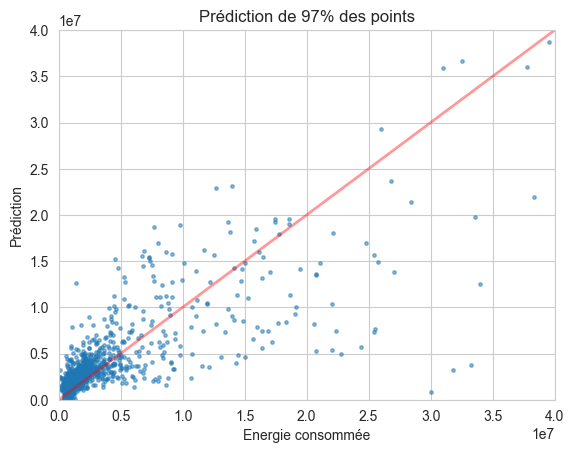

In [680]:
# Représentation graphique de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",alpha=0.5,s=6)
plt.plot([0.0, 40_000_000], [0.0, 40_000_000], 'r-', lw=2,alpha=0.4)

plt.xlim(0, 40_000_000)
plt.ylim(0, 40_000_000)

axes.set_xlabel('Energie consommée')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

In [681]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model)
coef

,coeff,coeff_sort
tx_gaz,1.931755e+06,1.931755e+06
BulType,1.959342e+05,1.959342e+05
NumberofFloors,-5.581869e+04,5.581869e+04
Council,5.472787e+04,5.472787e+04
Voisin,-3.338106e+04,3.338106e+04
Zip,-2.261172e+04,2.261172e+04
PPT,1.979786e+04,1.979786e+04
years,5.790578e+03,5.790578e+03
PropertyGFATotal,4.953696e+01,4.953696e+01
ThirdLargestPropertyUseTypeGFA,1.619759e+01,1.619759e+01


In [682]:
model.intercept_

array([-706911.89161734])

Text(0.5, 1.0, 'Coefficients de regression')

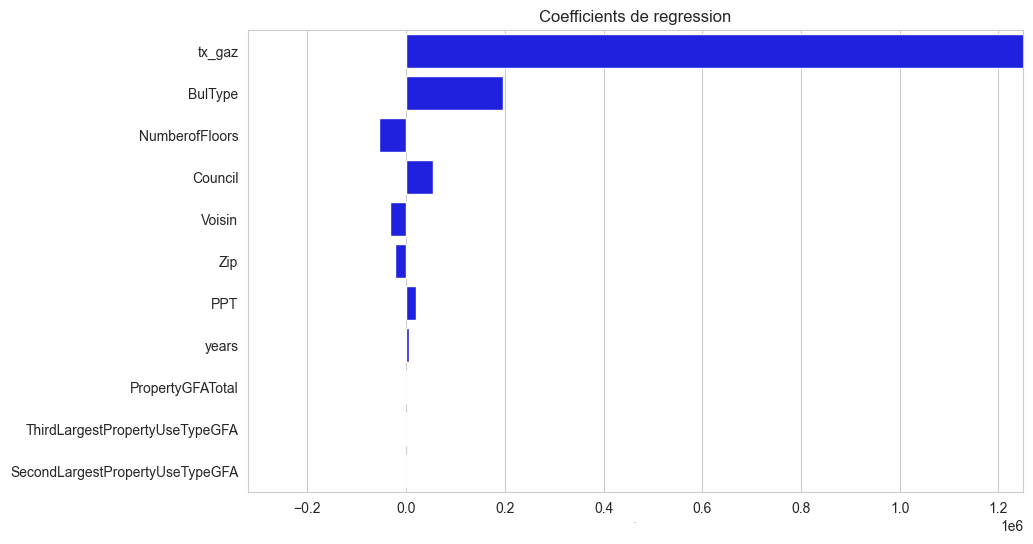

In [683]:
# Bar Plot des coeff

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-320_000, 1_250_000)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.2) Régression linéaire sur données centrées réduites
<a class="anchor" id="Section_2.2"></a>

Le modèle n'a pas l'air capable de prédire les 10 plus grandes valeur de la target.
Nous ne les conservons pas pour vérifier si le modèle est plus performant.
De plus nous travaillons dans cette partie sur les données centrées réduites

In [684]:
# Données centrées réduite sur toute la table entière

std_scale = preprocessing.StandardScaler().fit(df_float)
df_float_cr = std_scale.transform(df_float)

std_scale = preprocessing.StandardScaler().fit(target)
target_cr =  std_scale.transform(target)

# Permet d'avoir en output du modèle un DF
target_cr = pd.DataFrame(data=target_cr,columns=["SiteEnergyUse(kBtu)"],index=target.index)
df_float_cr = pd.DataFrame(data=df_float_cr,columns=df_float.columns,index=df_float.index)

# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr,
                                                    test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_cr = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_cr = tps2 - tps1
print("Temps de calcul : ",temps_cr,"ms")

Temps de calcul :  0.004996538162231445 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [685]:
print("R2 sur le set d'apprentissage: ",model_cr.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_cr.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.6055853600430678 
 R2 sur le set de test:  0.421200926220594


In [686]:
# Création d'un DF des valeurs prédites de X_test
pred = model_cr.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.8726365035736834


In [687]:
# Création d'un DF composée de la target la prédiction et les résidus

y_cr = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_cr = pd.DataFrame(y_cr).reset_index()
y_cr = y_cr.drop(columns=["index"])
pred = pd.concat([y_cr[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred


,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,-0.417141,-0.456544,-0.402369,-0.014772
1,-0.428199,-0.483138,-0.381505,-0.046694
2,-0.260279,-0.307297,-0.142221,-0.118057
3,-0.326544,-0.243394,-0.130448,-0.196095
4,-0.318308,-0.222790,-0.056093,-0.262215
...,...,...,...,...
998,-0.358892,-0.441438,-0.418946,0.060055
999,0.136396,-0.415501,-0.340470,0.476866
1000,-0.340402,-0.267084,-0.155386,-0.185016
1001,0.003858,0.173982,0.068318,-0.064460


Text(0.5, 1.0, 'Prédiction de 97% des points')

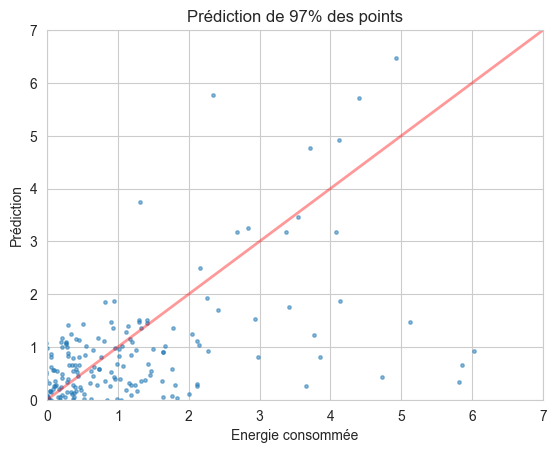

In [688]:
# Graphique de la target et de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",alpha=0.5,s=6)
plt.plot([0.0, 7], [0.0, 7], 'r-', lw=2,alpha=0.4)

plt.xlim(0, 7)
plt.ylim(0, 7)

axes.set_xlabel('Energie consommée')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

In [689]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model_cr)
coef

,coeff,coeff_sort
PropertyGFATotal,0.729513,0.729513
tx_gaz,0.053140,0.053140
NumberofFloors,-0.031217,0.031217
BulType,0.023561,0.023561
Zip,-0.023176,0.023176
years,0.019544,0.019544
ThirdLargestPropertyUseTypeGFA,0.017354,0.017354
Council,0.011826,0.011826
PPT,0.011750,0.011750
Voisin,-0.011070,0.011070


Text(0.5, 1.0, 'Coefficients de regression')

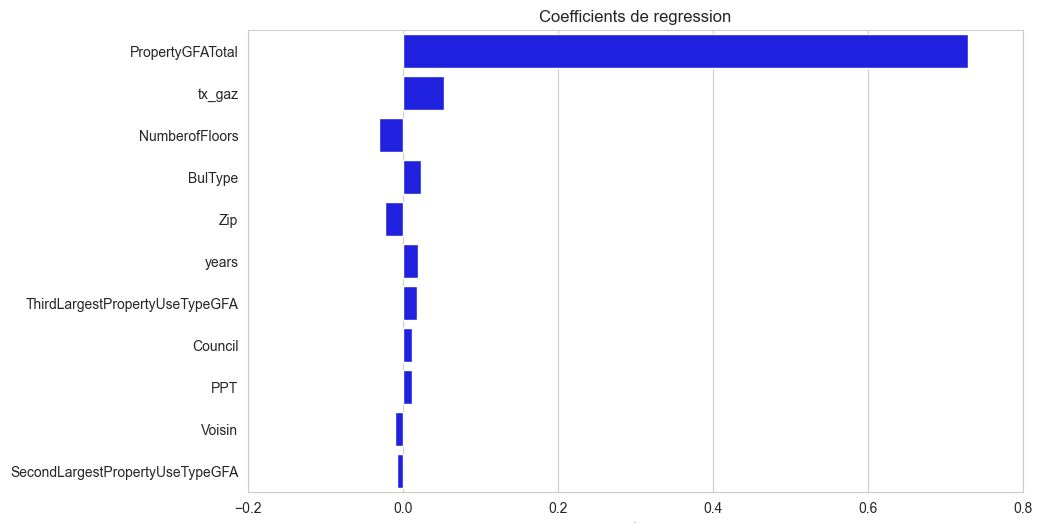

In [690]:
# Graphique des coeff
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-0.2, 0.8)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.3) Régression Ridge
<a class="anchor" id="Section_2.3"></a>

Regression Ridge sur les données centrées réduites.
Utilisation d'un gridsearch afin de tester plusieurs hyperparamètre

In [691]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr, test_size=0.3, random_state=0)

In [692]:
# Modèle RIDGE

tps1 = time.time()

score="r2"
param_grid = { "alpha":[0.2,0.4,0.6,0.8,0.9,2,5,9,10,11,12,50,100]}

model_ridge = GridSearchCV( Ridge(),
                            param_grid,
                            cv=10,
                            scoring=score )

model_ridge.fit(X_train,y_train)

tps2 = time.time()
temps_ridge = tps2 - tps1
print("Temps de calcul : ",temps_ridge,"ms")

Temps de calcul :  0.6287236213684082 ms


In [693]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_ridge.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 100}


In [694]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_ridge.cv_results_['mean_test_score'], # score moyen
        model_ridge.cv_results_['std_test_score'],  # écart-type du score
        model_ridge.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                    mean,
                                                    std*2,
                                                    params ) )

Résultats de la validation croisée :
mean_test_score = 0.596 (+/-0.181) for {'alpha': 0.2}
mean_test_score = 0.596 (+/-0.181) for {'alpha': 0.4}
mean_test_score = 0.596 (+/-0.181) for {'alpha': 0.6}
mean_test_score = 0.596 (+/-0.181) for {'alpha': 0.8}
mean_test_score = 0.596 (+/-0.181) for {'alpha': 0.9}
mean_test_score = 0.596 (+/-0.181) for {'alpha': 2}
mean_test_score = 0.596 (+/-0.181) for {'alpha': 5}
mean_test_score = 0.597 (+/-0.181) for {'alpha': 9}
mean_test_score = 0.597 (+/-0.181) for {'alpha': 10}
mean_test_score = 0.597 (+/-0.181) for {'alpha': 11}
mean_test_score = 0.597 (+/-0.181) for {'alpha': 12}
mean_test_score = 0.598 (+/-0.180) for {'alpha': 50}
mean_test_score = 0.599 (+/-0.181) for {'alpha': 100}


In [695]:
model_ridge.best_estimator_

Ridge(alpha=100)

In [696]:
reg_ridge= Ridge(alpha=0.2)
reg_ridge.fit(X_train,y_train)

Ridge(alpha=0.2)

In [697]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(reg_ridge)
coef

,coeff,coeff_sort
PropertyGFATotal,0.729328,0.729328
tx_gaz,0.053139,0.053139
NumberofFloors,-0.031143,0.031143
BulType,0.023575,0.023575
Zip,-0.023172,0.023172
years,0.019537,0.019537
ThirdLargestPropertyUseTypeGFA,0.017370,0.017370
Council,0.011820,0.011820
PPT,0.011753,0.011753
Voisin,-0.011070,0.011070


Text(0.5, 1.0, 'Coefficients de regression')

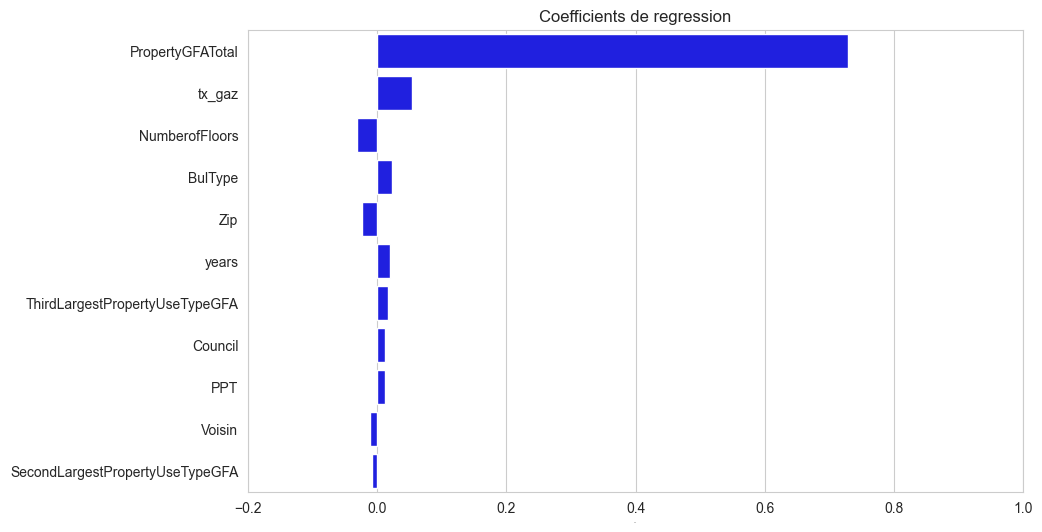

In [698]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2,1)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [699]:
print("R2 sur le set d'apprentissage: ",model_ridge.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_ridge.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.6031374052390486 
 R2 sur le set de test:  0.41661330327422563


In [700]:
# Création d'un DF des valeurs prédites de X_test
pred = model_ridge.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.8760879826898406


In [701]:
# Création d'un DF composée de la target la prédiction et les résidus

y_ridge = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_ridge = pd.DataFrame(y_ridge).reset_index()
y_ridge=y_ridge.drop(columns=["index"])
pred = pd.concat([y_ridge[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,-0.417141,-0.456544,-0.376772,-0.040369
1,-0.428199,-0.483138,-0.372766,-0.055432
2,-0.260279,-0.307297,-0.145730,-0.114549
3,-0.326544,-0.243394,-0.124430,-0.202113
4,-0.318308,-0.222790,-0.067665,-0.250643
...,...,...,...,...
998,-0.358892,-0.441438,-0.405421,0.046530
999,0.136396,-0.415501,-0.330262,0.466658
1000,-0.340402,-0.267084,-0.156542,-0.183860
1001,0.003858,0.173982,0.094246,-0.090388


Text(0.5, 1.0, 'Prédiction de 97% des points')

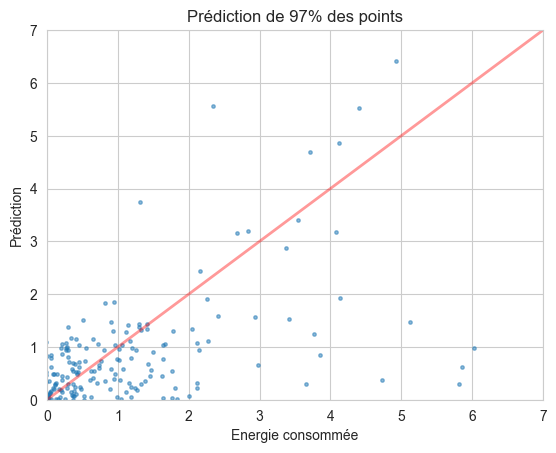

In [702]:
# Graphique de la target et de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",alpha=0.5,s=6)
plt.plot([0.0, 7], [0.0, 7], 'r-', lw=2,alpha=0.4)

plt.xlim(0, 7)
plt.ylim(0, 7)

axes.set_xlabel('Energie consommée')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

La régression Ridge n'a pas amélioré le pouvoir prédictif du modèle

## 2.4) Régression LASSO
<a class="anchor" id="Section_2.4"></a>

In [703]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr,
                                                    test_size=0.3, random_state=0)

In [704]:
# Modèle LASSO
tps1 = time.time()

score="r2"
param_grid = { "alpha":[0.1,0.2,0.4,0.6,0.8,0.9,2,5,9,10,11,12,50,100]}

model_lasso = GridSearchCV( Lasso(),
                      param_grid,
                      cv=10,
                      scoring=score)

model_lasso.fit(X_train,y_train)

tps2 = time.time()
temps_lasso = tps2 - tps1
print("Temps de calcul : ",temps_lasso,"ms")

Temps de calcul :  0.8151035308837891 ms


In [705]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_lasso.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.1}


In [706]:
# Afficher les performances correspondantes

result = 'mean_test_score'
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_lasso.cv_results_['mean_test_score'], # score moyen
        model_lasso.cv_results_['std_test_score'],  # écart-type du score
        model_lasso.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) pour {}".format( result,
                                                     mean,
                                                     std*2,
                                                     params) )

Résultats de la validation croisée :
mean_test_score = 0.598 (+/-0.213) pour {'alpha': 0.1}
mean_test_score = 0.569 (+/-0.232) pour {'alpha': 0.2}
mean_test_score = 0.430 (+/-0.201) pour {'alpha': 0.4}
mean_test_score = 0.186 (+/-0.093) pour {'alpha': 0.6}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 0.8}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 0.9}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 2}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 5}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 9}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 10}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 11}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 12}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 50}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 100}


In [707]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_lasso.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.1}


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [708]:
# Création d'un DF des valeurs prédites de X_test
pred = model_lasso.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.8860937031542888


In [709]:
print("R2 sur le set d'apprentissage: ",model_lasso.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_lasso.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.5854786745764325 
 R2 sur le set de test:  0.4032115961102126


In [710]:
reg_lasso = Lasso(alpha=0.2)
reg_lasso.fit(X_train,y_train)

Lasso(alpha=0.2)

In [711]:
# Création d'un DF composée de la target la prédiction et les résidus

y_lasso = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_lasso = pd.DataFrame(y_lasso).reset_index()
y_lasso=y_lasso.drop(columns=["index"])
pred = pd.concat([y_lasso[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,-0.417141,-0.456544,-0.296167,-0.120974
1,-0.428199,-0.483138,-0.312505,-0.115693
2,-0.260279,-0.307297,-0.204480,-0.055799
3,-0.326544,-0.243394,-0.165222,-0.161322
4,-0.318308,-0.222790,-0.152564,-0.165744
...,...,...,...,...
998,-0.358892,-0.441438,-0.286887,-0.072004
999,0.136396,-0.415501,-0.270953,0.407349
1000,-0.340402,-0.267084,-0.179775,-0.160626
1001,0.003858,0.173982,0.091187,-0.087329


Text(0.5, 1.0, 'Prédiction de 97% des points')

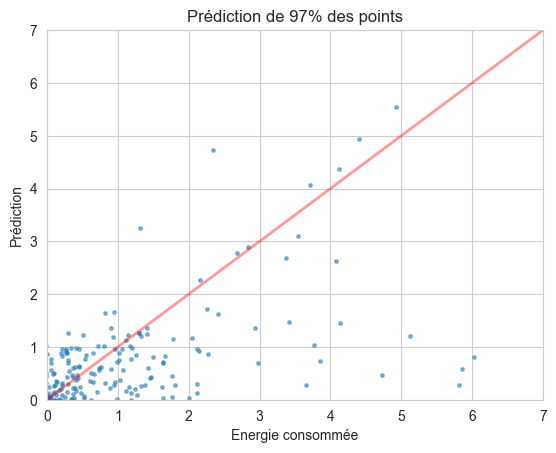

In [712]:
# Graphique de la target et de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",alpha=0.5,s=6)
plt.plot([0.0, 7], [0.0, 7], 'r-', lw=2,alpha=0.4)

plt.xlim(0, 7)
plt.ylim(0, 7)

axes.set_xlabel('Energie consommée')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

In [713]:
# Création d'un DF composé des coefficients

coef = pd.DataFrame(data=reg_lasso.coef_, columns = ["coeff"],index=df_float_cr.columns)
coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
PropertyGFATotal,0.515771,0.515771
years,0.000000,0.000000
NumberofFloors,0.000000,0.000000
SecondLargestPropertyUseTypeGFA,0.000000,0.000000
ThirdLargestPropertyUseTypeGFA,0.000000,0.000000
BulType,0.000000,0.000000
PPT,0.000000,0.000000
Zip,-0.000000,0.000000
Council,0.000000,0.000000
Voisin,-0.000000,0.000000


Text(0.5, 1.0, 'Coefficients de regression')

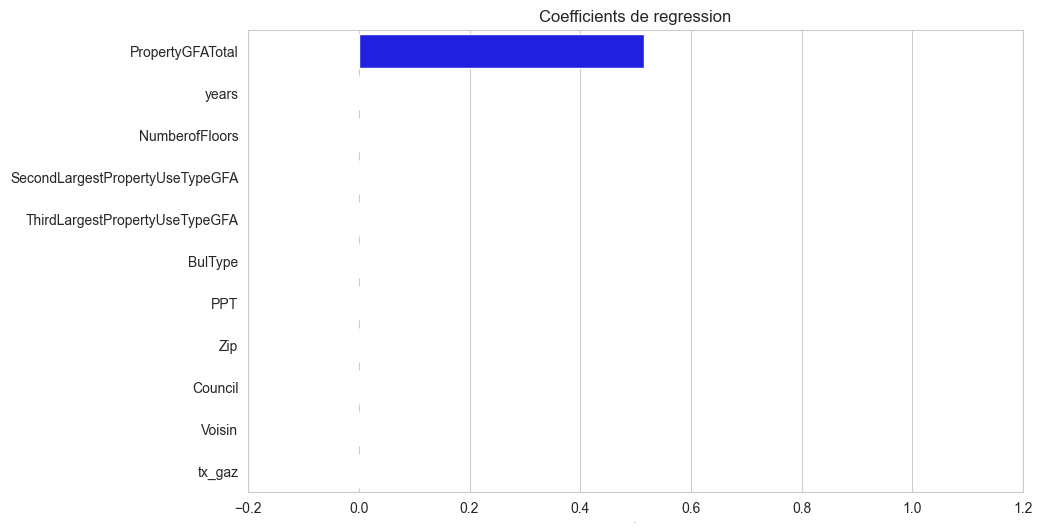

In [714]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2, 1.2)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

La régression LASSO montre toute son utilité:
- une seule variable permet d'expliquer le modèle
- la pénalité est efficace

## 2.5) Regression sur les 3 premieres composantes principales
<a class="anchor" id="Section_2.5"></a>

In [715]:
liste_r2=[]
liste_var=[]

for i in range(1,12):
    pca = PCA(n_components=i)
    pca.fit(df_float_cr)
    df_pca = pca.fit_transform(df_float_cr)

    X_train, X_test, y_train, y_test = train_test_split(df_pca, target_cr,
                                                    test_size=0.3, random_state=0)

    model_pca = LinearRegression().fit(X_train, y_train)

    liste_r2.append(model_pca.score(X_test, y_test))
    liste_var.append(pca.explained_variance_ratio_.sum())

print(liste_r2,"\n",liste_var)

[0.29640569504526604, 0.32048505069691013, 0.33335966628475, 0.3396081040668152, 0.3400608454127466, 0.34017806605901224, 0.34425968907348736, 0.35159495949185315, 0.3472398119600073, 0.3621513206413336, 0.4212009262205939] 
 [0.25707193451012184, 0.3978842005406106, 0.5241227933612125, 0.6126452407975927, 0.690416555199515, 0.763763558793593, 0.8325647825020799, 0.8893886817634893, 0.943052027625755, 0.9811697687253947, 1.0]


In [716]:
pca = PCA(n_components=3)
pca.fit(df_float_cr)

PCA(n_components=3)

In [717]:
pca.explained_variance_ratio_.sum()

0.5241227933612118

In [718]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes
df_pca = pca.fit_transform(df_float_cr)

In [719]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes

# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_pca, target_cr,
                                                    test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_pca = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_pca = tps2 - tps1
print("Temps de calcul : ",temps_pca,"ms")

Temps de calcul :  0.003991365432739258 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [720]:
print("R2 sur le set d'apprentissage: ",model_pca.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_pca.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.48101042932986793 
 R2 sur le set de test:  0.3333596662847499


In [721]:
# Création d'un DF des valeurs prédites de X_test
pred = model_pca.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.9365161164789474


In [722]:
# Création d'un DF composée de la target la prédiction et les résidus

y_pca = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_pca = pd.DataFrame(y_pca).reset_index()
y_pca = y_pca.drop(columns=["index"])
pred = pd.concat([y_pca[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,-0.417141,-0.456544,-0.213752,-0.203389
1,-0.428199,-0.483138,-0.372930,-0.055268
2,-0.260279,-0.307297,-0.364735,0.104456
3,-0.326544,-0.243394,0.199848,-0.526391
4,-0.318308,-0.222790,-0.215453,-0.102856
...,...,...,...,...
998,-0.358892,-0.441438,-0.515586,0.156694
999,0.136396,-0.415501,-0.146730,0.283126
1000,-0.340402,-0.267084,-0.364856,0.024454
1001,0.003858,0.173982,0.368533,-0.364675


Text(0.5, 1.0, 'Prédiction de 97% des points')

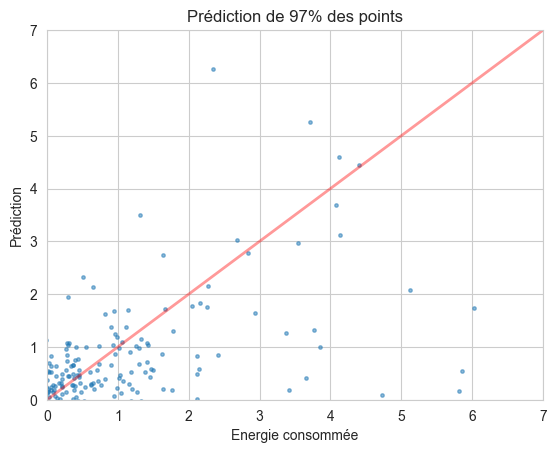

In [723]:
# Graphique de la target et de la prédiction
axes = plt.gca()
plt.scatter(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",alpha=0.5,s=6)
plt.plot([0.0, 7], [0.0, 7], 'r-', lw=2,alpha=0.4)

plt.xlim(0, 7)
plt.ylim(0, 7)

axes.set_xlabel('Energie consommée')
axes.set_ylabel('Prédiction')

plt.title('Prédiction de 97% des points')

In [724]:
# Création d'une fonction composé des coeff de la regression triés par ordre en valeur absolue
df_pca = pd.DataFrame(data=df_pca,columns=["comp_1","comp_2","comp_3"])
coef = pd.DataFrame(data=model_pca.coef_,columns=df_pca.columns)
coef = pd.DataFrame(data=coef.transpose().values,columns=["coeff"],
                        index=coef.transpose().index)
coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
comp_1,0.365911,0.365911
comp_2,0.147186,0.147186
comp_3,0.091855,0.091855


Text(0.5, 1.0, 'Coefficients de regression')

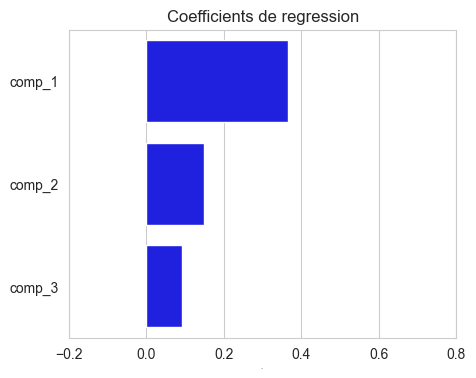

In [725]:
# Graphique des coeff

fig, ax = plt.subplots(figsize=(5, 4))
ax.set_xlim(-0.2, 0.8)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.6) Régression sur le log des données
<a class="anchor" id="Section_2.6"></a>

In [726]:
# Transformation des DF en log

df_float[df_float==0]=1
df_float_log = df_au_log(df_float)

target[target==0]=1
target_log = df_au_log(target)

C:\Users\fbbou\AppData\Local\Temp\ipykernel_5728\277867087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[target==0]=1
C:\Users\fbbou\AppData\Local\Temp\ipykernel_5728\277867087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[target==0]=1


In [727]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log, test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_log = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_log = tps2 - tps1
print("Temps de calcul : ",temps_log,"ms")

Temps de calcul :  0.025113582611083984 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [728]:
print("R2 sur le set d'apprentissage: ",model_log.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_log.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.6484196655398873 
 R2 sur le set de test:  0.6516302281864506


In [729]:
# Création d'un DF des valeurs prédites de X_test
pred = model_log.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.679971182665587


In [730]:
# Création d'un DF composée de la target la prédiction et les résidus

y_log = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_log = pd.DataFrame(y_log).reset_index()
y_log=y_log.drop(columns=["index"])
pred = pd.concat([y_log[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,13.344107,10.114397,13.661715,-0.317608
1,13.153030,9.945157,13.547467,-0.394436
2,14.587529,10.742336,14.255501,0.332028
3,14.229982,10.924373,14.897291,-0.667309
4,14.282022,10.976645,14.723205,-0.441182
...,...,...,...,...
998,13.994488,10.199138,13.658738,0.335750
999,15.616972,10.329735,14.006857,1.610115
1000,14.135795,10.860690,14.444386,-0.308591
1001,15.375191,11.660112,15.476673,-0.101482


Text(0.5, 1.0, 'Prédiction de 97% des points')

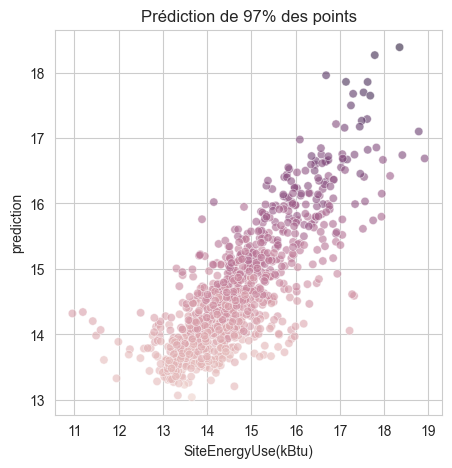

In [731]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)
plt.plot([11.0, 19], [11.0, 19], 'r-', lw=1,alpha=0.6)
plt.title('Prédiction de 97% des points')

In [732]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model_log)
coef

,coeff,coeff_sort
PropertyGFATotal,1.031407,1.031407
BulType,0.267156,0.267156
Zip,-0.073855,0.073855
years,0.073315,0.073315
tx_gaz,-0.060280,0.060280
Council,0.055405,0.055405
Voisin,-0.049829,0.049829
NumberofFloors,-0.037522,0.037522
PPT,-0.030869,0.030869
ThirdLargestPropertyUseTypeGFA,0.013131,0.013131


Text(0.5, 1.0, 'Coefficients de regression')

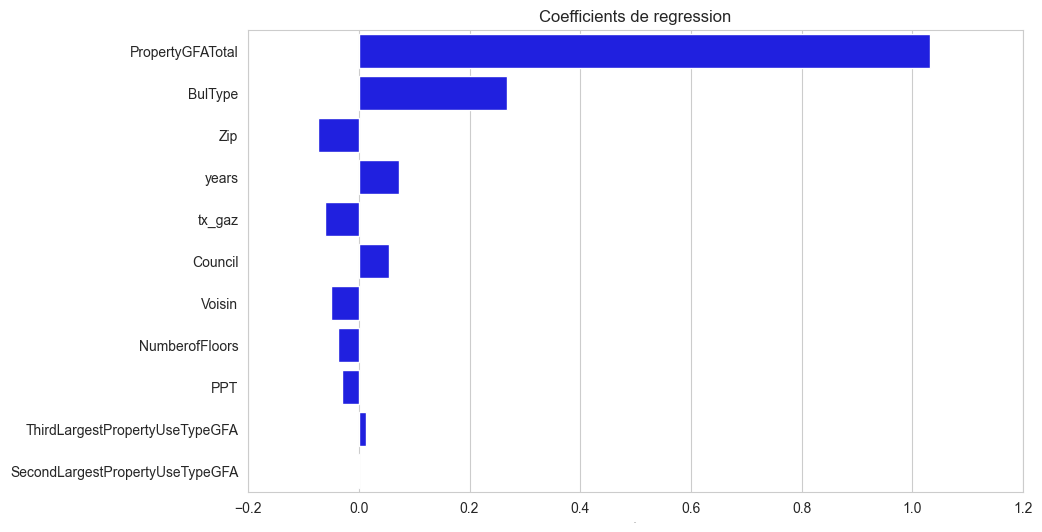

In [733]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2, 1.2)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.7) Gradient Boosting Regressor sur données en log
<a class="anchor" id="Section_2.7"></a>

In [734]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [735]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps d'execution

score ="r2"
param_grid = { "n_estimators":[50,100,200],
               "max_depth":[2,3,5],
               "alpha":[0.2,0.5,0.9]}

model_gbr = GridSearchCV( GradientBoostingRegressor(random_state=0),
                          param_grid,
                          cv = 10,
                          scoring = score)

model_gbr.fit(X_train,y_train)

tps2 = time.time()
temps_gbr = tps2 - tps1
print("Temps de calcul : ",temps_gbr,"ms")

C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was pass

Temps de calcul :  113.21886825561523 ms


In [736]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_gbr.cv_results_['mean_test_score'], # score moyen
        model_gbr.cv_results_['std_test_score'],  # écart-type du score
        model_gbr.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

Résultats de la validation croisée :
mean_test_score = 0.721 (+/-0.078) for {'alpha': 0.2, 'max_depth': 2, 'n_estimators': 50}
mean_test_score = 0.747 (+/-0.082) for {'alpha': 0.2, 'max_depth': 2, 'n_estimators': 100}
mean_test_score = 0.761 (+/-0.085) for {'alpha': 0.2, 'max_depth': 2, 'n_estimators': 200}
mean_test_score = 0.744 (+/-0.082) for {'alpha': 0.2, 'max_depth': 3, 'n_estimators': 50}
mean_test_score = 0.758 (+/-0.082) for {'alpha': 0.2, 'max_depth': 3, 'n_estimators': 100}
mean_test_score = 0.769 (+/-0.082) for {'alpha': 0.2, 'max_depth': 3, 'n_estimators': 200}
mean_test_score = 0.749 (+/-0.080) for {'alpha': 0.2, 'max_depth': 5, 'n_estimators': 50}
mean_test_score = 0.754 (+/-0.079) for {'alpha': 0.2, 'max_depth': 5, 'n_estimators': 100}
mean_test_score = 0.749 (+/-0.073) for {'alpha': 0.2, 'max_depth': 5, 'n_estimators': 200}
mean_test_score = 0.721 (+/-0.078) for {'alpha': 0.5, 'max_depth': 2, 'n_estimators': 50}
mean_test_score = 0.747 (+/-0.082) for {'alpha': 0.5, 'ma

In [737]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_gbr.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.2, 'max_depth': 3, 'n_estimators': 200}


In [738]:
gbr = GradientBoostingRegressor( n_estimators=200,
                                max_depth=3,
                                alpha=0.2)
gbr.fit(X_train,y_train)

C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.2, n_estimators=200)

### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [739]:
print("R2 sur le set d'apprentissage: ",model_gbr.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_gbr.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.8601487932188961 
 R2 sur le set de test:  0.7753156186564164


In [740]:
# Création d'un DF des valeurs prédites de X_test
pred = gbr.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.5572775860668846


In [741]:
# Création d'un DF composée de la target la prédiction et les résidus

y_bgr = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_bgr = pd.DataFrame(y_bgr).reset_index()
y_bgr = y_bgr.drop(columns=["index"])
pred = pd.concat([y_bgr[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,13.344107,10.114397,13.716599,-0.372492
1,13.153030,9.945157,13.532962,-0.379932
2,14.587529,10.742336,14.783740,-0.196211
3,14.229982,10.924373,14.271167,-0.041185
4,14.282022,10.976645,15.236174,-0.954152
...,...,...,...,...
664,14.679065,10.945529,14.769454,-0.090389
665,14.494171,11.547848,14.819595,-0.325424
666,13.895677,10.034296,14.041155,-0.145478
667,14.578931,10.651099,14.287287,0.291645


Text(0.5, 1.0, 'Prédiction de 97% des points')

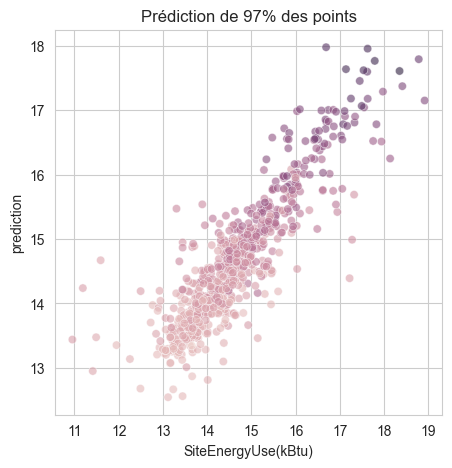

In [742]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)
plt.plot([12.0, 19], [12.0, 19], 'r-', lw=1,alpha=0.6)
plt.title('Prédiction de 97% des points')

In [743]:
coef =pd.DataFrame(data=gbr.feature_importances_,index=df_float.columns,columns=["coeff"])

coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
PropertyGFATotal,0.737914,0.737914
PPT,0.087988,0.087988
tx_gaz,0.073948,0.073948
BulType,0.044215,0.044215
years,0.017914,0.017914
NumberofFloors,0.009430,0.009430
ThirdLargestPropertyUseTypeGFA,0.008675,0.008675
SecondLargestPropertyUseTypeGFA,0.006762,0.006762
Zip,0.006757,0.006757
Voisin,0.004482,0.004482


Text(0.5, 1.0, 'Coefficients de regression')

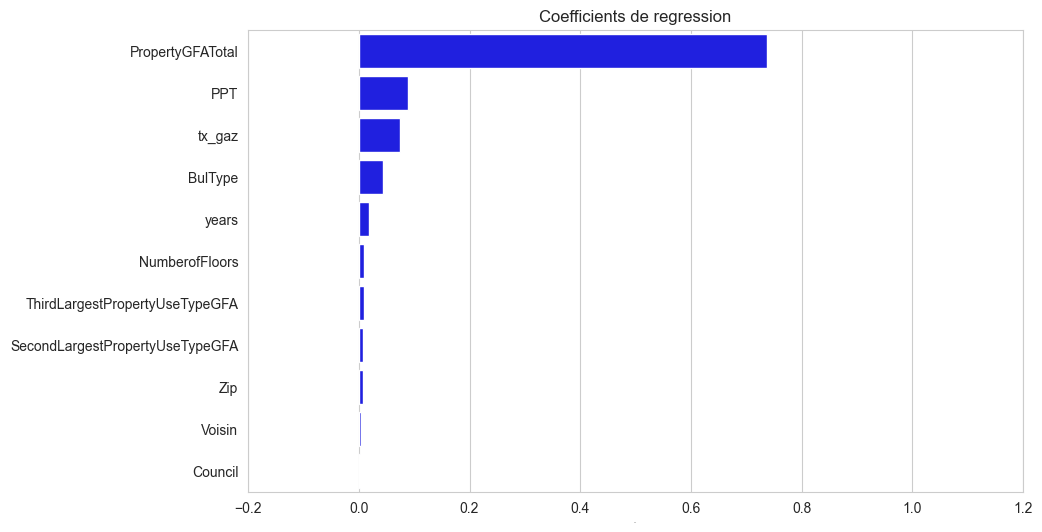

In [744]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2, 1.2)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.8) XGBoost sur données en log
<a class="anchor" id="Section_2.8"></a>

In [745]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [746]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps d'execution

score ="r2"
xgb = xgboost.XGBRegressor()
parameters = { "max_depth":[3,5,7],
               'objective':['reg:squarederror'],
               "booster" :["gbtree"],
               "n_estimators" : [100],
                "n_jobs" : [2],
               'learning_rate': [0.03, 0.05, 0.07]}

model_xgb = GridSearchCV( estimator=xgb,
                          param_grid= parameters,
                          cv = 5,
                          scoring = score
                          )

model_xgb.fit(X_train,y_train)

tps2 = time.time()
temps_xgb = tps2 - tps1
print("Temps de calcul : ",temps_xgb,"s")

Temps de calcul :  8.591005563735962 s


In [747]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_xgb.cv_results_['mean_test_score'], # score moyen
        model_xgb.cv_results_['std_test_score'],  # écart-type du score
        model_xgb.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

Résultats de la validation croisée :
mean_test_score = 0.349 (+/-0.040) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.365 (+/-0.052) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.368 (+/-0.051) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.733 (+/-0.045) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.745 (+/-0.047) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.747 (+/-0.040) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'n_jobs

In [748]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_xgb.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'booster': 'gbtree', 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [749]:
print("R2 sur le set d'apprentissage: ",model_xgb.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_xgb.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.9136279205185629 
 R2 sur le set de test:  0.7645966143692402


In [750]:
xgb = xgboost.XGBRegressor(parametre=model_xgb.best_params_)
xgb.fit(X_train,y_train)

[11:41:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "parametre" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1,
             parametre={'booster': 'gbtree', 'learning_rate': 0.07,
                        'max_depth': 7, 'n_estimators': 100, 'n_jobs': 2,
                        'objective': 'reg:squarederror'},
             predictor='auto', ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

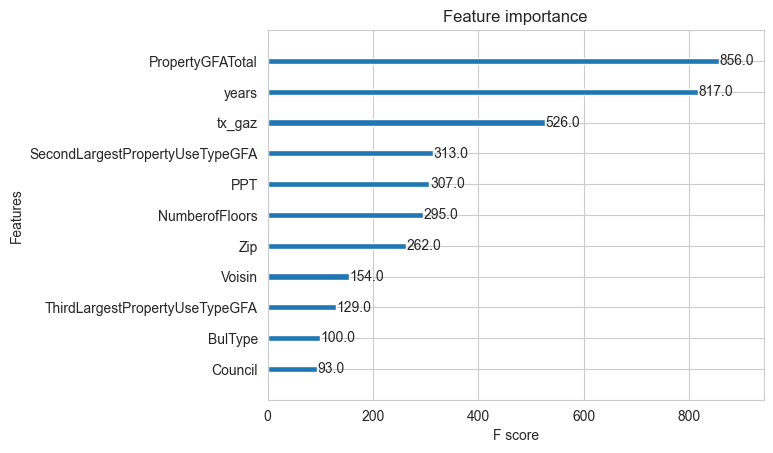

In [751]:
# Représentation graphique de l'importance de chaque variable
xgboost.plot_importance(xgb)

In [752]:
# Création d'un DF des valeurs prédites de X_test
pred = xgb.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.5914486927568751


In [753]:
# Création d'un DF composée de la target la prédiction et les résidus

y_xbg = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_xbg = pd.DataFrame(y_xbg).reset_index()
y_xbg = y_xbg.drop(columns=["index"])
pred = pd.concat([y_xbg[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,13.344107,10.114397,13.727325,-0.383218
1,13.153030,9.945157,13.451521,-0.298490
2,14.587529,10.742336,14.960442,-0.372913
3,14.229982,10.924373,14.202241,0.027741
4,14.282022,10.976645,15.185719,-0.903696
...,...,...,...,...
664,14.679065,10.945529,15.141445,-0.462380
665,14.494171,11.547848,14.849393,-0.355222
666,13.895677,10.034296,14.065215,-0.169538
667,14.578931,10.651099,14.654842,-0.075911


Text(0.5, 1.0, 'Prédiction de 97% des points')

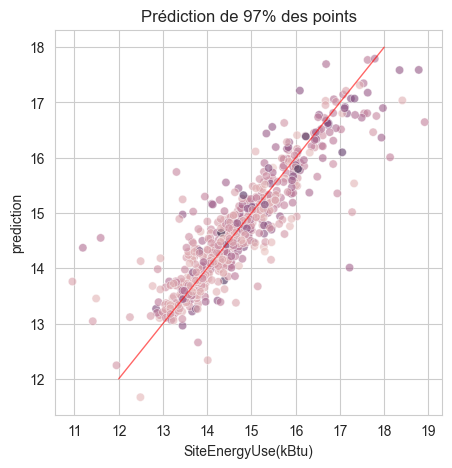

In [772]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)
plt.plot([12.0, 18], [12.0, 18], 'r-', lw=1,alpha=0.6)
plt.title('Prédiction de 97% des points')

## 2.9) Régression XGBoost avec la variable ENERGYSTARScore
<a class="anchor" id="Section_2.9"></a>

In [755]:
# On inclut la variable ENERGYscore ds le modèle
df_float["ENERGYSTARScore"]=df["ENERGYSTARScore"]
df_float_log = df_au_log(df_float)

In [756]:
# Imputation des données manquantes (ENERGYscore) par les KNN

imputer = KNNImputer(n_neighbors=5)

df_float_log = pd.DataFrame(data=imputer.fit_transform(df_float_log),
                            columns=df_float_log.columns)

In [757]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [758]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps d'execution

score ="r2"
xgb = xgboost.XGBRegressor()
parameters = { "max_depth":[3,5,7],
               'objective':['reg:squarederror'],
               "booster" :["gbtree"],
               "n_estimators" : [100],
                "n_jobs" : [1],
               'learning_rate': [0.03, 0.05, 0.07]}

model_xgb = GridSearchCV( estimator=xgb,
                          param_grid= parameters,
                          cv = 5,
                          scoring = score
                          )

model_xgb.fit(X_train,y_train)

tps2 = time.time()
temps_xgb_E = tps2 - tps1
print("Temps de calcul : ",temps_xgb_E,"ms")

Temps de calcul :  11.480090618133545 ms


In [759]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_xgb.cv_results_['mean_test_score'], # score moyen
        model_xgb.cv_results_['std_test_score'],  # écart-type du score
        model_xgb.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

Résultats de la validation croisée :
mean_test_score = 0.374 (+/-0.039) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.395 (+/-0.045) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.397 (+/-0.049) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.767 (+/-0.043) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.787 (+/-0.038) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.791 (+/-0.040) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'n_jobs

In [760]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_xgb.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'booster': 'gbtree', 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}


In [761]:
xgb = xgboost.XGBRegressor(parametre=model_xgb.best_params_)
xgb.fit(X_train,y_train)

[11:42:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "parametre" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1,
             parametre={'booster': 'gbtree', 'learning_rate': 0.07,
                        'max_depth': 7, 'n_estimators': 100, 'n_jobs': 1,
                        'objective': 'reg:squarederror'},
             predictor='auto', ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

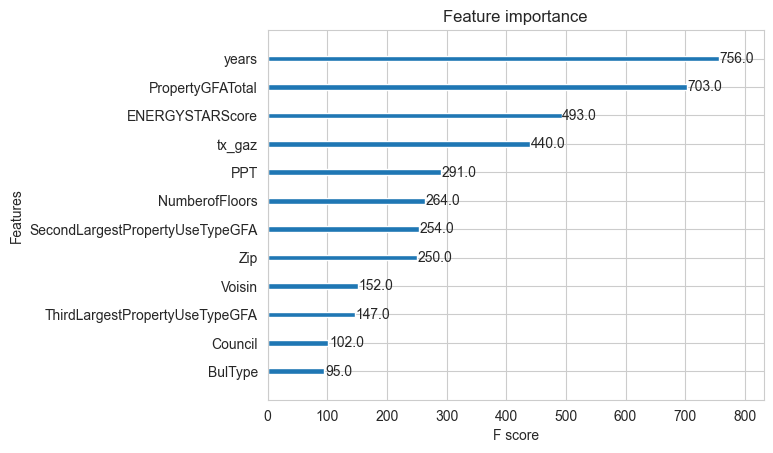

In [762]:
# Représentation graphique de l'importance de chaque variable
xgboost.plot_importance(xgb)

### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [763]:
print("R2 sur le set d'apprentissage: ",model_xgb.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_xgb.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.9416798835344077 
 R2 sur le set de test:  0.7925739960593754


In [764]:
# Création d'un DF des valeurs prédites de X_test
pred = model_xgb.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.5360744330377207


In [765]:
# Création d'un DF composée de la target la prédiction et les résidus

y_xgb_star = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,
                          right_index=True)
y_xgb_star = pd.DataFrame(y_xgb_star).reset_index()
y_xgb_star = y_xgb_star.drop(columns=["index"])
pred = pd.concat([y_xgb_star[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,13.344107,10.013731,13.680396,-0.336289
1,13.153030,10.534759,13.309454,-0.156423
2,14.587529,11.535645,14.636970,-0.049441
3,14.229982,11.475224,14.167389,0.062593
4,14.282022,11.537618,15.236619,-0.954597
...,...,...,...,...
664,14.679065,12.570205,14.817041,-0.137977
665,14.494171,10.883504,14.727737,-0.233566
666,13.895677,11.100496,13.816815,0.078861
667,14.578931,10.450452,14.474420,0.104512


<AxesSubplot: xlabel='SiteEnergyUse(kBtu)', ylabel='prediction'>

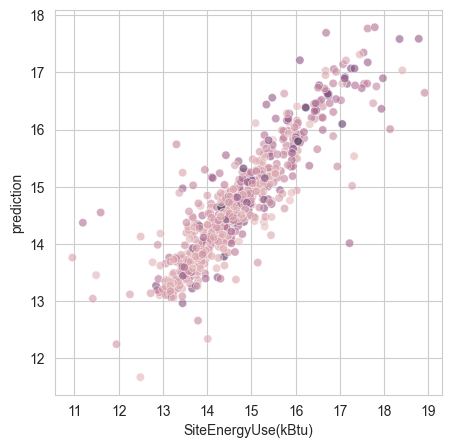

In [766]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)

## Conclusion partie 2
<a class="anchor" id="Conclusion"></a>

# 📄 References<a class="anchor" id="Références"></a>
- [Data Seattle](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy)
- [Librairie Pandas](https://pandas.pydata.org/docs/user_guide/index.html#)
- [Librairie scikit-learn](https://scikit-learn.org/stable/user_guide.html)
- [Librairie XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html)